## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob
import os

import numpy as np
import scipy as sp
import scipy.io

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import signal
from scipy.signal import find_peaks

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        data_fls and ref_fls are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def LoadTroikaRefFile(ref_fl):
    """
    Loads and extracts ground truth pulse rate measured from ECG from a troika reference data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ref = LoadTroikaDataFile(data_fls[0])

    Args:
        ref_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for heart rate measured through ECG signals.
    """
    data = sp.io.loadmat(ref_fl)['BPM0']
    return data


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est = percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band, fs):
    """
    Butterworth bandpass filter algorithm.
    
    Returns:
        Bandpass filtered signal
    """          
    b, a = sp.signal.butter(2, pass_band, btype='bandpass', fs = fs)
    return sp.signal.filtfilt(b, a, signal)

def FindPPGDominantFreq(ppg_fft, ppg_freqs, accx_max_freq, accy_max_freq, accz_max_freq):
    """
    Find dominant PPG frequency. 
    
    If there is only one ppg dominant frequency candidate, choose it; 
    If there are multiple candidates, choose the strongest PPG frequency dissimilar to 
    dominant accelerometer frequency. 

    Note: 
        distance_bps is the maximum distance (unit: Hz) between Accelerometers aggregated frequency 
        and PPG frequency for them to be considered too similar will be considered to be 
        too similar. This can occur if arm movements have strong contribution
        to PPG signals.
    
    Return:
        Dominant PPG frequency (unit: Hz)
    """
    
    similarity_dist = 10/60 # Hyperparameter that was tested from 5 BPM to 20 BPM
    
    sorted_ppg_fft = np.sort(ppg_fft)[::-1][:10]
    ppg_max_fft = sorted_ppg_fft[0]
    
    for i, fft in enumerate(sorted_ppg_fft):
        ppg_freq = ppg_freqs[np.argwhere(ppg_fft == fft)[0][0]]

        if ppg_freq == 0:
            continue
        elif np.abs(ppg_freq - accx_max_freq) = similarity_dist or \
            np.abs(ppg_freq - accy_max_freq) = similarity_dist or \
            np.abs(ppg_freq - accz_max_freq)  = similarity_dist: 
            selected_peak_freq = ppg_freq
            if i == len(sorted_ppg_fft)-1:
                selected_peak_freq = ppg_freqs[np.argwhere(ppg_fft == ppg_max_fft)[0][0]]
            continue
        else:
            selected_peak_freq = ppg_freq
            break

    return selected_peak_freq

def CalcConfidence(pred_pr, ref_pr, ppg_freqs, ppg_fft):
    '''Calculates a confidence value for a given frequency by computing
       the ratio of energy concentrated near that frequency compared to the full signal.
       
       Args:
           pred_pr: estimated pulse rate (unit: Hz)
           ref_pr: ground truth pulse rate (unit: Hz)
           ppg_freqs, ppg_fft: Freqs, FFT of PPG signal
       
       Returns:
           confidence, error: confidence and error value for pulse rate prediction.
    '''
    
    bps_sum_window = 10/60 
    low_window = pred_pr-bps_sum_window
    high_window = pred_pr+bps_sum_window
    window = (ppg_freqs=low_window) & (ppg_freqs =high_window)

    confidence = np.sum(ppg_fft[window])/np.sum(ppg_fft)
    error = np.abs(pred_pr-ref_pr) * 60
        
    return confidence, error

def RunPulseRateAlgorithm(data_fl, ref_fl, verbose=False):
    """
    Runs algorithm to estimate Pulse rate.
    
    Usage:
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        
    Args:
       data_fl: (str) filepath to a troika .mat file with ECG, PPG, and ACC measurement data.
       ref_fl: (str) filepath to a troika .mat file with ref pulse rate.
       
    Returns:
        errors: a numpy array of errors between pulse rate estimates and corresponding reference heart rates.
        confidence: a numpy array of confidence estimates for each pulse rate.
    
    """
    
    # Constants
    fs = 125
    nfft_window_size = fs*8
    noverlap = fs*6
    pass_band = (40/60, 240/60)
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    """
    STEP 1: load & preprocess data
        Load PPG channel 2 and Accelerometer 3 direction signals;
        Preprocess with bandpass filter;
        Compute spectrogram and get Freqs and FFT Spectra for each PPG and Accelerometer signals.
    """
    
    filtered_ppg = BandpassFilter(ppg, pass_band, fs)
    ppg_fft, ppg_freqs,_,_ = plt.specgram(filtered_ppg, NFFT = nfft_window_size, Fs=fs, noverlap=noverlap)
    plt.close()
    
    
    filtered_accx = BandpassFilter(accx, pass_band, fs)     
    accx_fft, accx_freqs,_,_ = plt.specgram(filtered_accx, NFFT = nfft_window_size, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accy = BandpassFilter(accy, pass_band, fs)     
    accy_fft, accy_freqs,_,_ = plt.specgram(filtered_accy, NFFT = nfft_window_size, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accz = BandpassFilter(accz, pass_band, fs)     
    accz_fft, accz_freqs,_,_ = plt.specgram(filtered_accz, NFFT = nfft_window_size, Fs=fs, noverlap=noverlap)
    plt.close()
    
    """
    STEP 2: compute pulse rate estimates (unit: Hz)

    """
    
    estimated_pulse_rates = []
    for i in range(ppg_fft.shape[1]):
        accx_max_freq = accx_freqs[np.argmax(accx_fft[:,i])]
        accy_max_freq = accy_freqs[np.argmax(accy_fft[:,i])]
        accz_max_freq = accz_freqs[np.argmax(accz_fft[:,i])]
        peak_freq = FindPPGDominantFreq(ppg_fft[:,i], ppg_freqs, accx_max_freq, accy_max_freq, accz_max_freq)
        estimated_pulse_rates.append(peak_freq)
        
    """
    STEP 3: compute confidence and error for estimation:
    
    """
    
    confidences = []
    errors = []    

    # Load ground truth pulse rate estimated from ECG signals
    ecgdata = LoadTroikaRefFile(ref_fl)
    
    for i in range(ppg_fft.shape[1]):
        pred = estimated_pulse_rates[i]
        ref = ecgdata[i][0]/60
        confidence, error = CalcConfidence(pred, ref, ppg_freqs, ppg_fft[:,i])
        
        confidences.append(confidence)
        errors.append(error)

    return np.array(errors), confidences

In [2]:
Evaluate()

10.720090095500963

## EDA

In [5]:
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
print('File contains total {:0.2f} min of data'.format(len(accx)/125/60))

File contains total 5.06 min of data


In [6]:
fs = 125
nfft_window_size = fs*8
noverlap = fs*6
pass_band = (40/60, 240/60)

### Spectrogram: 
- ppg_specs.shape = (501, 148) = frequency (hz) x window, intensity value = magnitude
- len(ppg)/125 = 37937 data points, sampling rate = 125 data points per sec = 303.5 sec
- window size = 8 sec, overlap = 6 sec, shift = 2 sec = (len(ppg)/125-8)/2 = 147.748 total windows

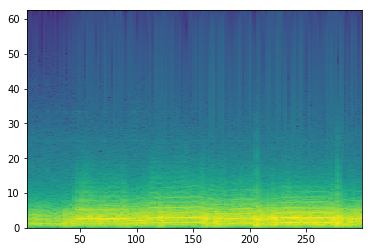

In [7]:
filtered_ppg = BandpassFilter(ppg, pass_band, fs)
ppg_fft, ppg_freqs,_,_ = plt.specgram(filtered_ppg, NFFT = nfft_window_size, Fs=fs, noverlap=noverlap)

Text(0.5,1,'first window FFT')

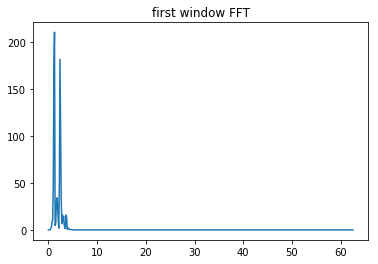

In [8]:
plt.plot(ppg_freqs, ppg_fft[:,0])
plt.title("first window FFT")

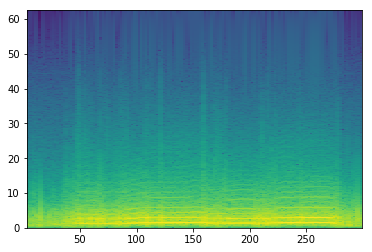

In [11]:
filtered_accx = BandpassFilter(accx, pass_band, fs)     
accx_fft, accx_freqs,_,_ = plt.specgram(filtered_accx, NFFT = nfft_window_size, Fs=fs, noverlap=noverlap)

Text(0.5,1,'ACCX window FFT')

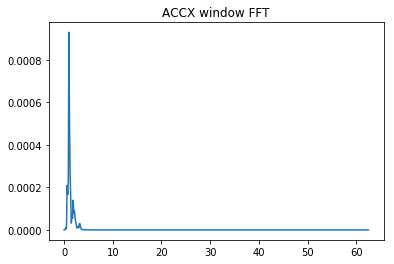

In [10]:
plt.plot(accx_freqs, accx_fft[:,0])
plt.title("ACCX window FFT")

In [18]:
filtered_accy = BandpassFilter(accy, pass_band, fs)     
accy_fft, accy_freqs,_,_ = plt.specgram(filtered_accy, NFFT = nfft_window_size, Fs=fs, noverlap=noverlap)

filtered_accz = BandpassFilter(accz, pass_band, fs)     
accz_fft, accz_freqs,_,_ = plt.specgram(filtered_accz, NFFT = nfft_window_size, Fs=fs, noverlap=noverlap)
plt.close()

## Compute pulse rate estimate for one FFT window

In [13]:
fs = 125
nfft_window_size = fs*8
noverlap = fs*6
pass_band = (40/60, 240/60)
distance_bps = 10/60
i = 0

In [25]:
accx_max_freq = accx_freqs[np.argmax(accx_fft[:,i])]
accy_max_freq = accy_freqs[np.argmax(accy_fft[:,i])]
accz_max_freq = accz_freqs[np.argmax(accz_fft[:,i])]
peak_freq = FindPPGDominantFreq(ppg_fft[:,i], ppg_freqs, accx_max_freq, accy_max_freq, accz_max_freq)
estimated_pulse_rates_bps = []
estimated_pulse_rates_bps.append(peak_freq)
peak_freq * 60

75.0

## Compute confidence and error 
- For this computation, The energy in the frequency spectrum that is concentrated near the pulse rate estimate is
determined by summing the frequency spectrum around the pulse rate estimate with a window of bpm_sum_window.
- The bpm_sum_window will be chosen to be less than the performance criterion of 15BPM difference 
between estimated pulse rate and reference pulse rate.
- The Confidence Estimate is the Energy around the Pulse Rate Estimate divided by the sum of the 
entire frequency spectrum.

In [22]:
ecgdata = LoadTroikaRefFile(ref_fls[0])
ref = ecgdata[i][0]
print('Reference pulse rate is', ref, 'bpm')

Reference pulse rate is 74.3392070485 bpm


In [27]:
print('Predicted pulse rate is',estimated_pulse_rates_bps[0] * 60, 'bpm')

Predicted pulse rate is 75.0 bpm


In [28]:
bps_sum_window = 10/60
low_window = estimated_pulse_rates_bps[i] - bps_sum_window 
high_window = estimated_pulse_rates_bps[i] + bps_sum_window
print(low_window, high_window)

1.08333333333 1.41666666667


In [29]:
window = (ppg_freqs= low_window) & (ppg_freqs =high_window)
print(ppg_fft[:,i][window])

[ 173.3435555   210.48714552    4.77676441]


In [30]:
confidence=np.sum(ppg_fft[:,i][window])/np.sum(ppg_fft[:,i])
error = np.abs(estimated_pulse_rates_bps[i]*60-ref)
print(confidence, error)

0.373464768838 0.660792951542


-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

 - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
 - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
 - **Algorithhm Description** will include the following:
   - how the algorithm works
   - the specific aspects of the physiology that it takes advantage of
   - a describtion of the algorithm outputs
   - caveats on algorithm outputs 
   - common failure modes
 - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.


**Code Description**:
This code builds an algorithm that estimates pulse rate from the PPG signal and a 3-axis accelerometer, assuming pulse rate will be restricted between 40BPM (beats per minute) and 240BPM. 
  
*Inputs*:
  * .mat files with ECG, PPG, and accelerometer signals
  * .mat files with ground truth pulse rates calculated from ECG measurements
  * All files should be in same folder directory "./datasets/troika/training_data"

*Outputs*:
  * produces an estimation confidence evaluated against the ground truth pulse rate calculated from ECG signals measured contemporaneously. A higher confidence value means that this estimate should be more accurate than an estimate with a lower confidence value.

*Logic Steps*:
  1. Load data filenames: LoadTroikaDataset() loads input signals and ground truth signal filenames into two variables, 
    * data_fls which contains a list of all files with a name starting with 'DATA_' in the directory
    * ref_fls which contains a list of all files with a name starting with 'REF_' in the directory

  2. Load data: LoadTroikaDataFile(data_fl) loads a data file path and return a numpy array with PPG and 3-axis accelerometer measurements.

  3. Run algorithm to estimate pulse rate: RunPulseRateAlgorithm(data_fl, ref_fl) takes a data file path and a corresponding reference file path as inputs, load the data file, process the data and uses dominant frequency in PPG signal to estimate pulse rate frequency. Details of the algorithm will be described in the "Algorithm Description" section. 
  
  The function will output the error and confidence of estimation. The Confidence of each determined pulse rate is calulated as the sum of intensity magnitudes within 10 BPM of the charactistic frequncy divided by the sum of intensity magnitudes across all frequencies. And the absolute error between the determined pulse rate and the reference ECG pulse rate data are calculated. The error and confidence are returned from this function.

4. Evaluate: Evaluation() will load all data files and run the RunPulseRateAlgorithm() on each. AggregateErrorMetric() accumulates estimation confidence and results from each file to determine the mean absolute error of 90% availability of those outputs.

**Data Description**:
The **Troika**[1] dataset is used to build this algorithm. 

Each dataset with the similar name 'DATA_01_TYPE01' contains a variable 'sig'. It has 6 rows. The first row is a simultaneous recording of ECG, which is recorded from the chest of each subject. The
second row and the third row are two channels of PPG, which are recorded from the wrist of each
subject. The last three rows are simultaneous recordings of acceleration data (in x-, y-, and z-axis).

During data recording, each subject ran on a treadmill with changing speeds. For datasets with
names containing 'TYPE01', the running speeds changed as follows:

rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)

For datasets with names containing 'TYPE02', the running speeds changed as follows: 

rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)

For each dataset with the similar name 'DATA_01_TYPE01', the ground-truth of heart rate can be
calculated from the simultaneously recorded ECG signal (i.e. the first row of the variable 'sig'). 

For convenience, calculated ground-truth heart rate is provided, stored in the datasets with the corresponding name, say 'REF_01_TYPE01'. In each of this kind of datasets, there is a variable 'BPM0', which gives the BPM value in every 8-second time window. Note that two successive time windows overlap by 6 seconds. Thus the first value in 'BPM0' gives the calcualted heart rate ground-truth in the first 8 seconds, while the second value in 'BPM0' gives the calculated heart rate ground-truth from the 3rd second to the 10th second.

Note that this dataset is limited in its number of subjects and age range. The age of each subject is not provided, and the duration of each activity is a limited duration. Future work could expand this dataset to include more activity features such as lengthened activity duration, other activity intervals or types, as well as other demographic features such as gender. 

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

**Algorithm Description**:
*Physiology*: 
This algorithm utilizes Photoplethysmography (PPG) sensors worn on a user's wrist to estimate pulse rate. PPG sensors emit green light into a user's wrist. As blood cells absorbs such light, the sensor can detect the amount of light reflecting back as the blood flow changes in our body. Particularly,
  * When the heart contracts, blood leaves the hurt and flows into the body, absorbs more green light and causing a trough in sensor signal; 
  * When the heart relaxes, blood returns to fill the heart, causing a rise in sensor signal. 
  * As the heart beats with a steady rhythm, readings from PPG will form similar waveform whose period can be used to determine the pulse rate.

However, in addition to the heart contractions, arm motions can also cause blood movement through the wrist. For example, in the datasets used in this project, a subject running or walking can introduce periodic changes in blood flow due to the arm movement. 3-axis accelerometer is therefore used to measure, identify and hopefully separate such noise from PPG signals. 

*Algorithm descriptions*:
  - STEP 1: load & preprocess data
    - Load PPG channel 2 and Accelerometer 3 direction signals;
    - Preprocess with bandpass filter to restrict input signals to a reasonable range (40-240 bpm);
    - Compute spectrogram and get Freqs and FFT Spectra for each PPG and Accelerometer signals segmented into rolling 8 second windows with 6 second overlap. 
  - STEP 2: compute pulse rate estimates (unit: Hz) by identifying a dominant frequency in PPG signal filtered out by accelerometer frequencies. 
    - If there is only one ppg dominant frequency candidate, choose it; 
    - If there are multiple candidates, choose the strongest PPG frequency dissimilar to 
    dominant accelerometer frequency. 
  - STEP 3: compute confidence and error for estimation and return as output. 

*Outputs*:
Up to 10 characteristic frequencies for the PPG data are compared against dominant characteristic frequencies for each of the three accelerometers per time window. 
  - If there is only one ppg dominant frequency candidate, choose it; 
  - If there are multiple candidates, choose the strongest PPG frequency dissimilar to 
    dominant accelerometer frequency. 

The Confidence of each determined pulse rate is sums the intensity magnitudes within 10 BPM the pulse rate estimate, and divide it by the sum of that across all frequencies. This formula is similar to signal-to-noise ratio calculation, where a higher result indicates fewer noise frequencies that do not represent the pulse rate. One may select BPM estimates above a threshold confidence while discarding those below the threshold.

The Absolute Errors are calculated between the determined pulse rate and the reference ECG pulse rate data.

*Caveats on this Algorithm's output*: The output from this algorithm only takes into consideration periodic noises such as arm movement but does not account for any other noise sources such as ambient light or shifts in sensor position.
  
*Common failure modes*: When algorithm picks a higher frequency signal not from the heart rate but from strong hand movements, arm movement, finger movement.

**Algorithm Performance**:
This algorithm meets the project's requirement that the mean absolute error at 90% availability is less than 15 BPM on the test dataset. We got 10.72BPM as MAE on training dataset. 


-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 